In [20]:
from sklearn.datasets import load_diabetes, load_boston, fetch_california_housing, load_iris, load_breast_cancer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

### Gradient Boosting

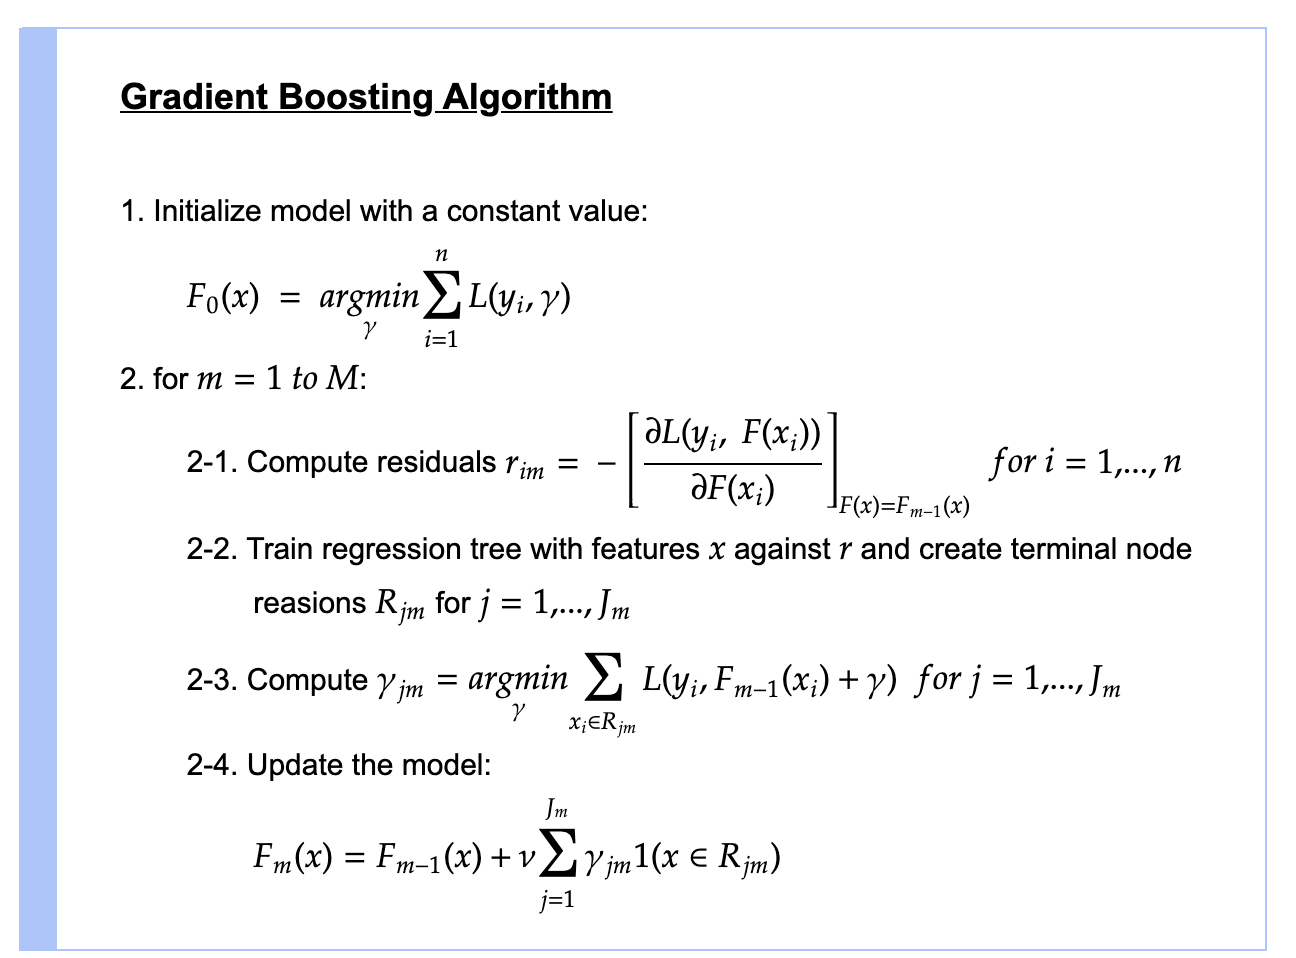

Note on $\gamma$ : "Other step size [than $\gamma$ ] schemes are also possible (e.g., a constant step size γm=γ0, a decreasing step sizes scheme γm=γ0/m−−√, etc.). Different step size schemes can provide the same guarantees on the training loss (e.g., ensure convergence to a local minimum of the training loss) that hold under different assumptions of the empirical training loss and/or the weak learning algorithm. However, modifying the step size scheme can affect the generalization properties of the algorithm in ways that to the best of my knowledge are not yet fully understood."

### Regression

In [51]:
class L2Boosting(object):
    def __init__(self,n_rounds=100, lr=.1,
                 max_depth=3,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 subsample = 1.,
                 rng=42):
        self.random_state = rng
        self.n_rounds = n_rounds
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.lr = lr
        self.subsample = subsample
    def fit(self, X, y):
        self.models = []
        # calculate base
        self.base   = np.mean(y)
        preds  = np.repeat(self.base, y.shape[0])
        # calculate pseudo residuals
        resids = y - preds
        # calculate sse
        self.loss   = [ np.power(resids, 2).sum() ]
        
        for i in range(self.n_rounds):
            # If subsample < 1., sample the training set. Theoretically reduces variance for higher bias. In practice it doesnt really help much
            sample = np.random.choice(list(range(y.shape[0])), int(y.shape[0] * self.subsample), replace=False)
            # Fit a decision tree regressor to the residuals and add it to the list of weak models
            self.models += [ DecisionTreeRegressor(random_state=self.random_state,
                                                   max_depth=self.max_depth,
                                                   min_samples_split=self.min_samples_split,
                                                   min_samples_leaf=self.min_samples_leaf).fit(X[sample], resids[sample]) ]
            # The new prediction is base + sum of all weak learners h_i(x) scaled by lr
            preds  = self.base + np.array([self.lr * model.predict(X) for model in self.models]).sum(axis=0) 
            # calculate new pseudo residuals
            resids = y - preds
            # calculate sse
            self.loss   += [ np.power(resids, 2).sum() ]
    
    def plot(self):
        return pd.Series(self.loss).plot(grid=True, title="learning curve - vanilla implementation", ylabel="SSE", xlabel="round")

    def predict(self, X):
        return self.base + np.array([self.lr * model.predict(X) for model in self.models]).sum(axis=0) 

In [52]:
X, y = fetch_california_housing(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=42
)

In [53]:
m0 = RandomForestRegressor(n_jobs=-1).fit(X_train, y_train)
m1 = GradientBoostingRegressor().fit(X_train, y_train)

<AxesSubplot: title={'center': 'learning curve - vanilla implementation'}, xlabel='round', ylabel='SSE'>

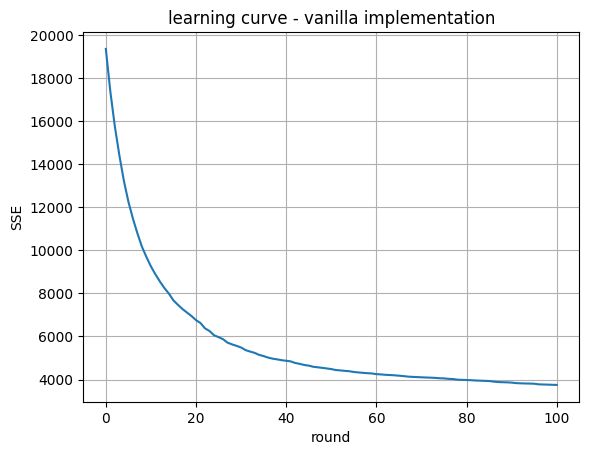

In [54]:
m = L2Boosting()
m.fit(X_train, y_train)
m.plot()

Compare test mses

In [55]:
pd.DataFrame({"RandomForest" : [np.power(m0.predict(X_test) - y_test, 2).mean()],
              "GBM sklearn" : [np.power(m1.predict(X_test) - y_test, 2).mean()],
              "GBM vanilla impl." : [np.power(m.predict(X_test) - y_test, 2).mean()]}, index=["test-mse"]).T
              

,test-mse
RandomForest,0.254285
GBM sklearn,0.288350
GBM vanilla impl.,0.288363


### Classificaiton

Prerequisites :

$$\text{log_odds} = \log(\frac{p}{1-p})$$

$$p = \text{odds} \times (1-p)$$

$$p = \frac{\exp(\text{log_odds})}{\exp(1 + \text{log_odds})}$$

$$p = \frac{\exp(\log(\frac{p}{1-p})}{\exp(1 + \log(\frac{p}{1-p}))}$$

$$
\sigma(x) =\frac{1}{1+e^{-x}}=\frac{e^x}{e^x+1}
$$

Similar to logistic regression, log_odds will serve as the base. Log odds are real valued and symmetric around 0. The negative gradient aka pseudo residual is always real.


In [57]:
class NLLBoosting(object):
    def __init__(self,n_rounds=100, lr=.1,
                 max_depth=3,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 subsample=1.,
                 rng=42):
        self.random_state = rng
        self.n_rounds = n_rounds
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.subsample = subsample
        self.lr = lr
        self.sigmoid = lambda log_odds : np.exp(log_odds)/(1+np.exp(log_odds))
    def fit(self, X, y):
        unique, counts = np.unique(y, return_counts=True)
        q, p = counts / counts.sum()
        odds = p / q # i.e. p / (1-p) or simply counts[1] / counts[0]
        log_odds = np.log(odds)

        self.models = []
        self.base   = log_odds
        # calculate the base  [the symmetric, real valued equivalent of the mean in binary classification should be log of the odds]
        preds  = np.repeat(p, counts.sum())
        # calculate cross entropy/nll
        self.loss   = [ -(y*np.log(preds)+(1-y)*np.log(1-preds)).mean() ] 
        # calculate pseudo residuals 
        resids = y - preds

        for i in range(self.n_rounds):
            # If subsample < 1., sample the training set. Theoretically reduces variance for higher bias. In practice it doesnt really help much
            sample = np.random.choice(list(range(y.shape[0])), int(y.shape[0] * self.subsample), replace=False)
            # fit decision tree and add to list of weak learners
            self.models += [ DecisionTreeRegressor(random_state=self.random_state,
                                                   max_depth=self.max_depth,
                                                   min_samples_split=self.min_samples_split,
                                                  min_samples_leaf=self.min_samples_leaf).fit(X[sample], resids[sample]) ]
            # The new estimate is base + sum of all weak learners h_i(x) scaled by lr
            # Judging by the math, this shouldnt work !!
            log_odds  = self.base + np.array([self.lr * model.predict(X) for model in self.models]).sum(axis=0) # / (preds * (1 - preds)))
            # transform to probability
            preds = self.sigmoid(log_odds) # / (preds * (1 - preds)))
            # calculate new residuals
            resids = y - preds
            # calculate new nll
            self.loss   += [ -(y*np.log(preds)+(1-y)*np.log(1-preds)).mean() ] 
    
    def plot(self):
        return pd.Series(self.loss).plot(grid=True, title="learning curve - vanilla implementation", ylabel="NLL", xlabel="round")

    def predict(self, X):
        return self.sigmoid(self.base + np.array([self.lr * model.predict(X) for model in self.models]).sum(axis=0))
    
    

In [58]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.33, random_state=42
)

In [59]:
m0 = RandomForestClassifier(n_jobs=-1).fit(X_train, y_train)
m1 = GradientBoostingClassifier().fit(X_train, y_train)

<AxesSubplot: title={'center': 'learning curve - vanilla implementation'}, xlabel='round', ylabel='NLL'>

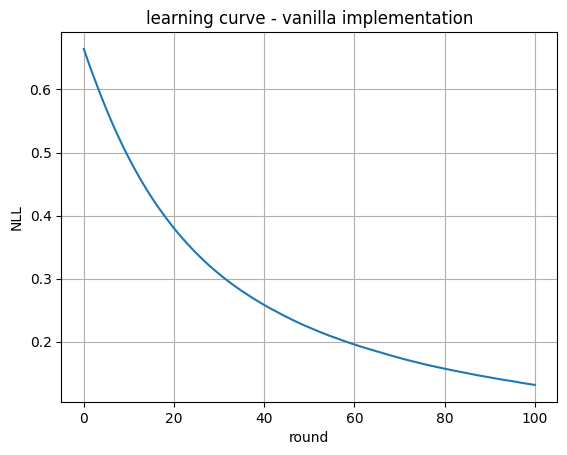

In [60]:
m = NLLBoosting()
m.fit(X_train, y_train)
m.plot()

Compare test accs

In [61]:
pd.DataFrame({"RandomForest" : [np.where(y_test == m0.predict(X_test), 1, 0).mean()],
              "GBM sklearn" : [np.where(y_test == m1.predict(X_test), 1, 0).mean()],
              "GBM vanilla impl." : [np.where(y_test == np.where(m.predict(X_test) > .5, 1, 0), 1, 0).mean()]}, index=["test-accuracy"]).T
              

,test-accuracy
RandomForest,0.962766
GBM sklearn,0.957447
GBM vanilla impl.,0.962766


test on another dataset

In [71]:
df = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")
df["Sex"] = df["Sex"].apply(lambda x : {"male" : 1, "female" : 0}[x])
df = df[["Survived", 'Pclass', 'Sex', 'Age', 'SibSp']].dropna()
X = df[[ 'Pclass', 'Sex', 'Age', 'SibSp']].values
y = df["Survived"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [72]:
m0 = RandomForestClassifier(n_jobs=-1).fit(X_train, y_train)
m1 = GradientBoostingClassifier().fit(X_train, y_train)

<AxesSubplot: title={'center': 'learning curve - vanilla implementation'}, xlabel='round', ylabel='NLL'>

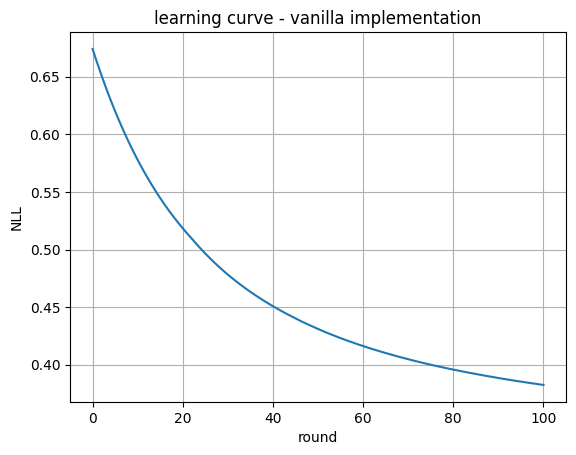

In [73]:
m = NLLBoosting()
m.fit(X_train, y_train)
m.plot()

Compare test accs

In [74]:
pd.DataFrame({"RandomForest" : [np.where(y_test == m0.predict(X_test), 1, 0).mean()],
              "GBM sklearn" : [np.where(y_test == m1.predict(X_test), 1, 0).mean()],
              "GBM vanilla impl." : [np.where(y_test == np.where(m.predict(X_test) > .5, 1, 0), 1, 0).mean()]}, index=["test-accuracy"]).T
              

,test-accuracy
RandomForest,0.786047
GBM sklearn,0.800000
GBM vanilla impl.,0.804651


In [ ]:
import graphviz
from sklearn import tree

In [ ]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

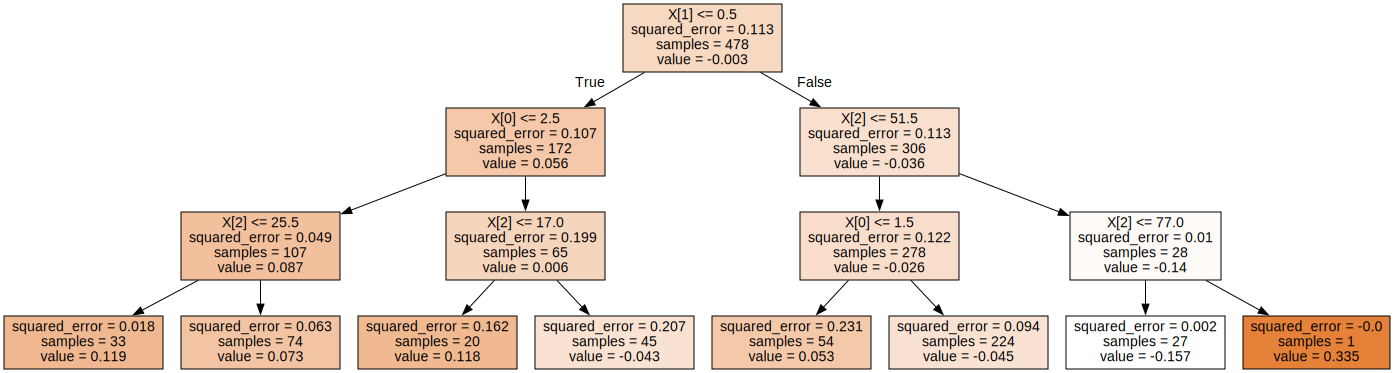

In [ ]:
dtree = m.models[-1]
dot_data = tree.export_graphviz(dtree, out_file=None,  
                                filled=True)
graphviz.Source(dot_data, format="png") 

In [33]:
dtree = m.models[0]

In [34]:
leaf_indices  = dtree.apply(X_train)
unique_leaves = np.unique(leaf_indices)
n_leaves      = len(unique_leaves)
    

In [41]:
n_leaves

8

In [43]:
dtree.tree_.value.shape

(15, 1, 1)

In [42]:
dtree.tree_.value[0, 0 , 0]

-5.969190739093415e-17

In [45]:
-.0167 / (.67 * .33)

-0.07553143374038895

In [15]:
X_train.shape

(478, 4)

In [ ]:
'C:/Program Files/Graphviz/bin/'